# Hanabi game -- Analysis of simulation results

## Data import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results = {}
player_configs = [2, 3, 4, 5]

for n in player_configs:
    results_file = "summary_{}_players.csv".format(n)
    df = pd.read_csv(results_file, sep=';')
    df = df.drop(df.columns[0], axis=1)

    # filter out games where the score is 0
    df = df.loc[df["score"] > 0]

    # add efficiency as ratio score : hint
    eff = df.apply(lambda x: x.score/x.hints if x.hints > 0 else float('nan'), axis=1)
    df.insert(df.shape[1], "efficiency", eff)

    # add speed as the ratio score : moves
    speed = df.apply(lambda x: x.score/x.moves, axis=1)
    df.insert(df.shape[1], "speed", speed)
    
    results[n] = df

## Basic plots and correlations

In [3]:
from itertools import product
from sklearn.linear_model import LinearRegression

predictors = [
    "avg_implicit_info",
    "total_implicit_info",
    "avg_explicit_info",
    "total_explicit_info"
]

predicted = [
    "score",
    "efficiency",
    "speed"
]

def basic_plots(n, predictors, predicted, regression_model=LinearRegression):
    fig, axs = plt.subplots(len(predictors), len(predicted), figsize=(15, 20),
        facecolor = 'white')
    df = results[n]
    corrs = pd.DataFrame(columns=['x', 'y', 'r2'])

    for i, j in product(range(len(predictors)), range(len(predicted))):
        x = predictors[i]
        y = predicted[j]

        # scatter plot
        axs[i, j].scatter(df[x], df[y])
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel(y)

        # linear regression
        X = df[x].to_numpy().reshape(-1, 1)
        Y = df[y].to_numpy().reshape(-1, 1)
        reg = regression_model().fit(X, Y)
        r2 = reg.score(X, Y)
        latest_cor = pd.DataFrame.from_dict({'x': [x], 'y': [y], 'r2': [r2]})
        corrs = pd.concat([corrs, latest_cor], ignore_index=True)

    plt.show()
    return corrs

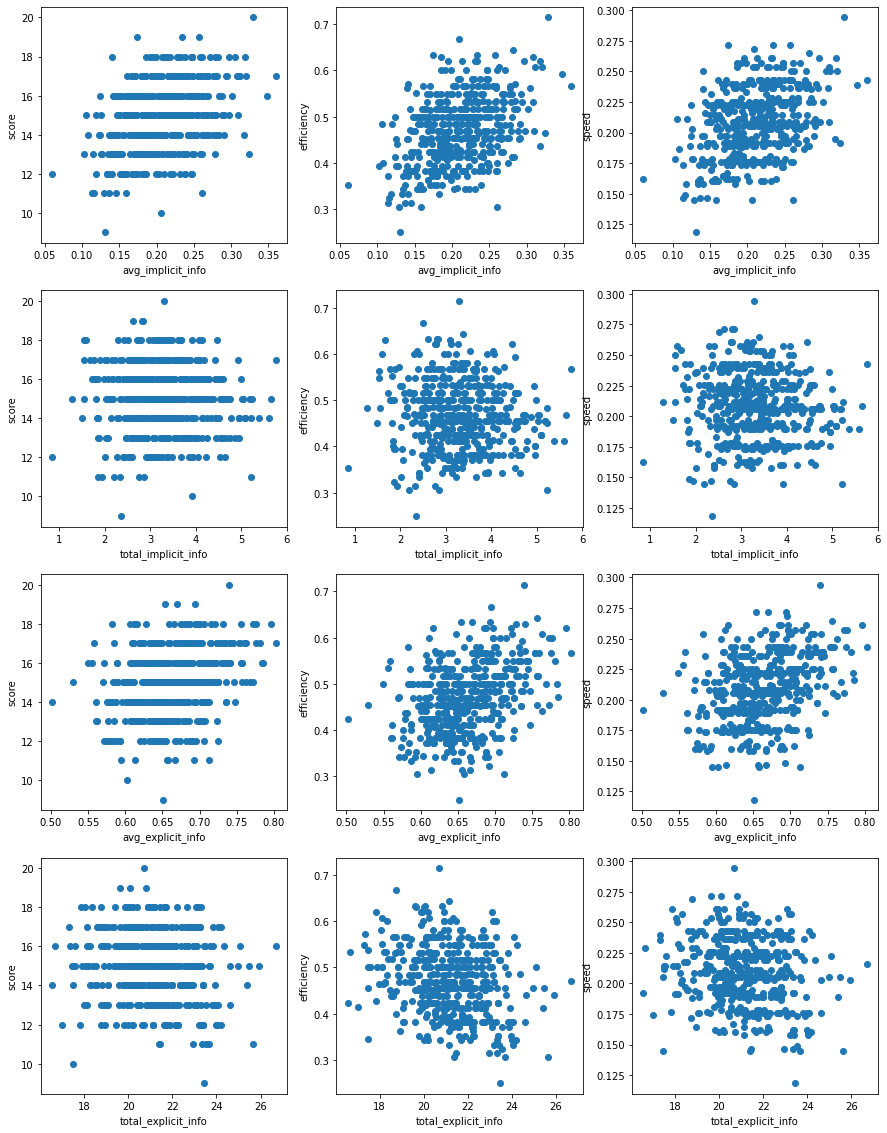

,x,y,r2
0,avg_implicit_info,score,0.133095
1,avg_implicit_info,efficiency,0.163064
2,avg_implicit_info,speed,0.151265
3,total_implicit_info,score,0.002454
4,total_implicit_info,efficiency,0.005814
5,total_implicit_info,speed,0.004049
6,avg_explicit_info,score,0.096102
7,avg_explicit_info,efficiency,0.121397
8,avg_explicit_info,speed,0.110941
9,total_explicit_info,score,0.016666


In [4]:
basic_plots(2, predictors, predicted)

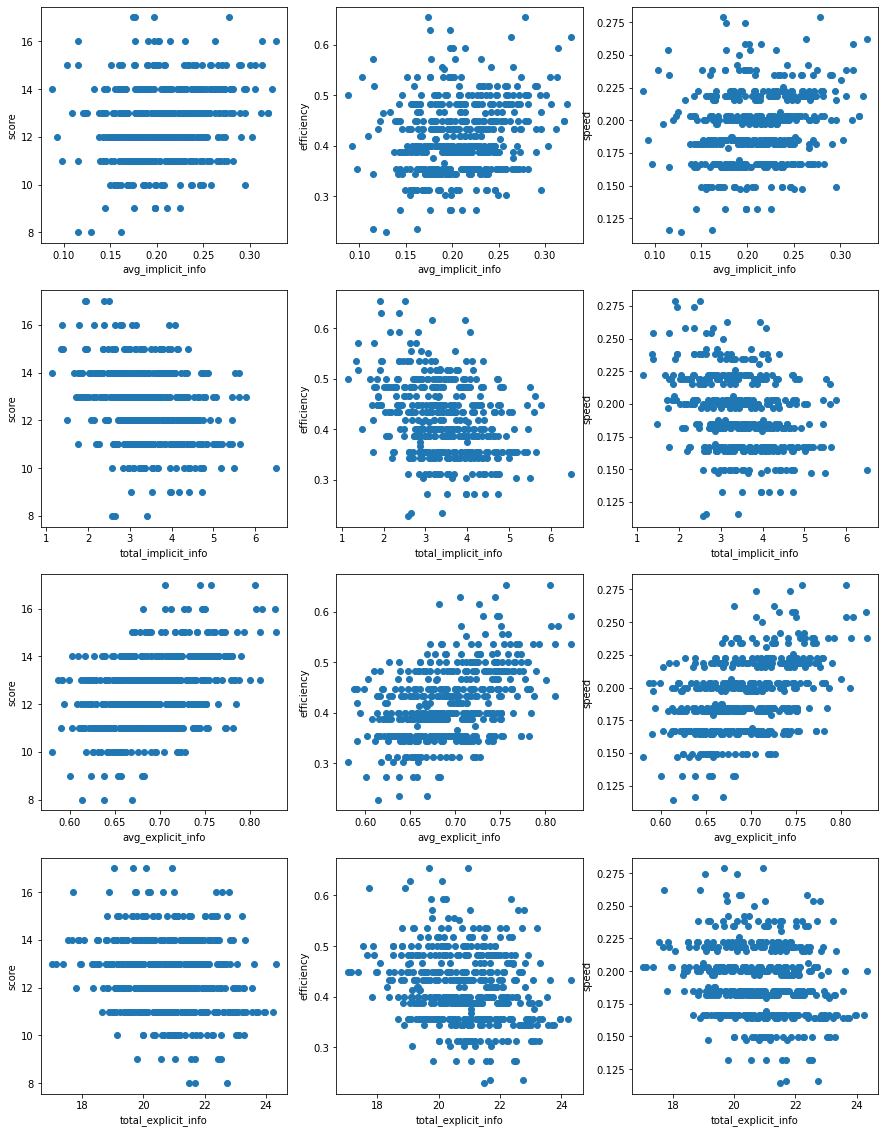

,x,y,r2
0,avg_implicit_info,score,0.038104
1,avg_implicit_info,efficiency,0.039477
2,avg_implicit_info,speed,0.039081
3,total_implicit_info,score,0.092557
4,total_implicit_info,efficiency,0.095364
5,total_implicit_info,speed,0.094412
6,avg_explicit_info,score,0.190004
7,avg_explicit_info,efficiency,0.201996
8,avg_explicit_info,speed,0.197192
9,total_explicit_info,score,0.042302


In [5]:
basic_plots(3, predictors, predicted)

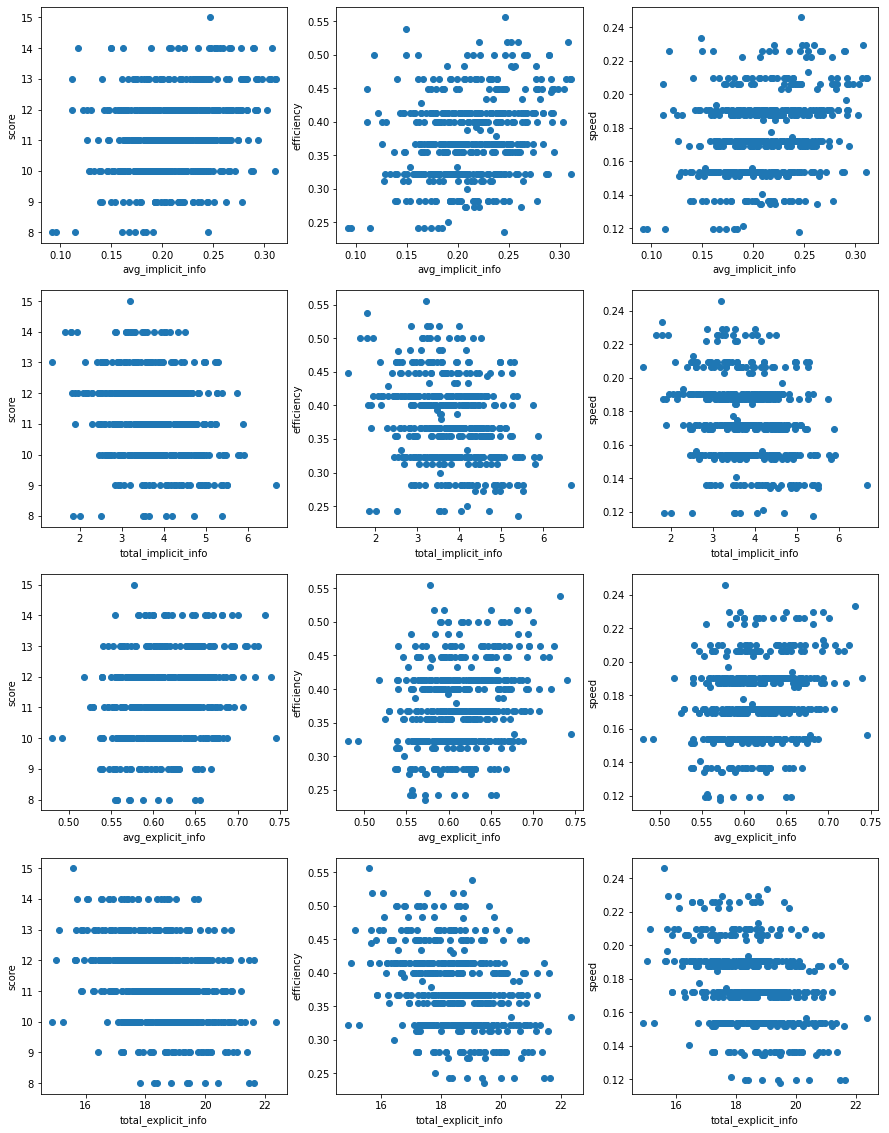

,x,y,r2
0,avg_implicit_info,score,0.079427
1,avg_implicit_info,efficiency,0.076479
2,avg_implicit_info,speed,0.078207
3,total_implicit_info,score,0.058851
4,total_implicit_info,efficiency,0.065604
5,total_implicit_info,speed,0.062636
6,avg_explicit_info,score,0.050524
7,avg_explicit_info,efficiency,0.058393
8,avg_explicit_info,speed,0.054833
9,total_explicit_info,score,0.110608


In [6]:
basic_plots(4, predictors, predicted)

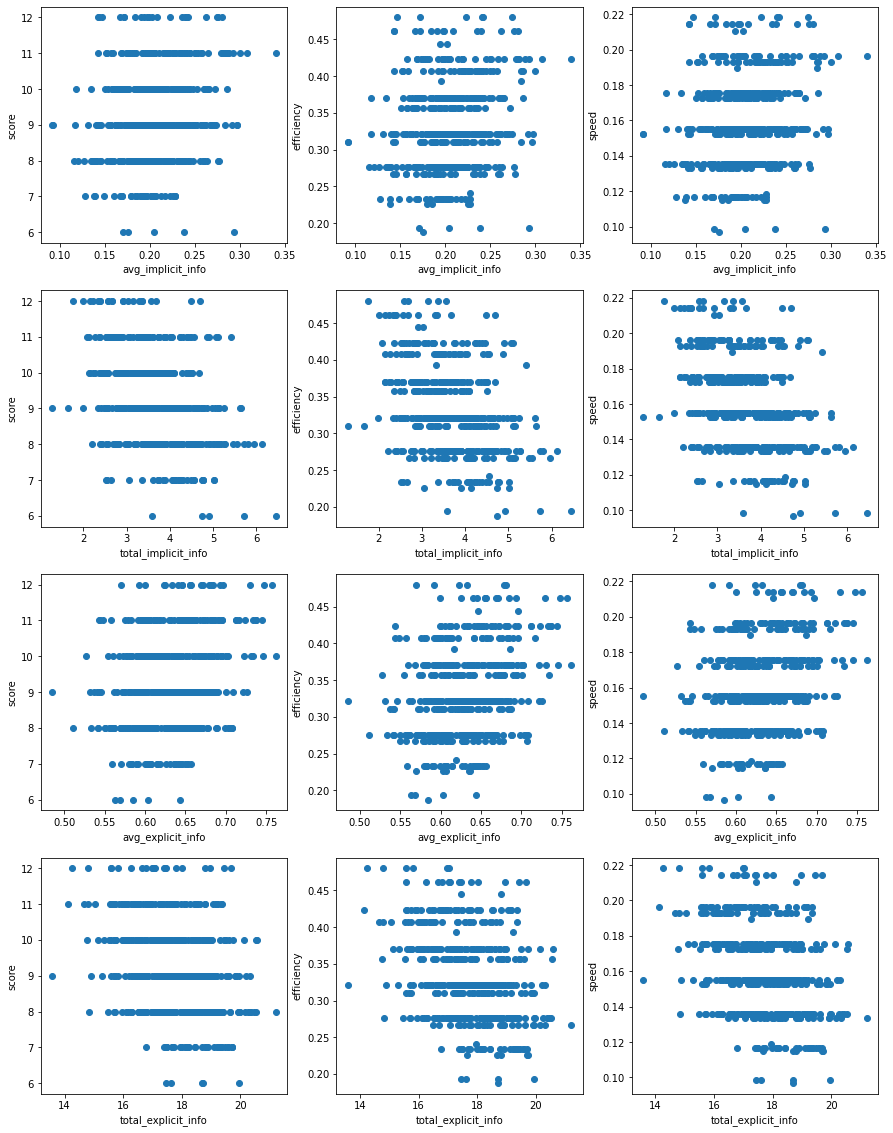

,x,y,r2
0,avg_implicit_info,score,0.029737
1,avg_implicit_info,efficiency,0.031167
2,avg_implicit_info,speed,0.030584
3,total_implicit_info,score,0.14242
4,total_implicit_info,efficiency,0.143681
5,total_implicit_info,speed,0.143611
6,avg_explicit_info,score,0.07125
7,avg_explicit_info,efficiency,0.076141
8,avg_explicit_info,speed,0.074115
9,total_explicit_info,score,0.109816


In [7]:
basic_plots(5, predictors, predicted)

In conclusion, there is no correlation between the amount of information
provided by hints, either by the average per hint nor by the total amount
exchanged throughout the game. Try multidimensional correlations for score,
efficiency, and speed.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

def md_correlation(n, predictors, target,
    regression_model=Ridge(solver='saga')):
    df = results[n]
    X, y = df[predictors].to_numpy(), df[target].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
        random_state=0)
    pipe = Pipeline(
        [('scaler', StandardScaler()), ('regression', regression_model)]
    )
    pipe.fit(X_train, y_train)
    r2 = pipe.score(X_test, y_test)
    return pipe[1].coef_, pipe[1].intercept_, r2

In [9]:
predictors = ["moves", "hints", "avg_explicit_info", "avg_implicit_info",
"total_explicit_info", "total_implicit_info"]
predicted = ["score", "efficiency", "speed"]


corrs = pd.DataFrame(columns=['num_players', 'target'] + predictors + \
    ['intercept', 'R2'])

for n, target in product(player_configs, predicted):
    coefs, intercept, r2 = md_correlation(n, predictors, target)
    d = {'num_players': [n], 'target': [target], 'intercept': [intercept],
    'R2': [r2]}
    for i, x in enumerate(predictors):
        d[x] = [coefs[i]]
    latest_cor = pd.DataFrame.from_dict(d)
    corrs = pd.concat([corrs, latest_cor], ignore_index=True)

# corrs.to_csv("all_correlations.csv", sep=';', decimal=',')
print(corrs)

   num_players      target     moves     hints avg_explicit_info  \
0            2       score -0.229246 -0.229246          0.219118   
1            2  efficiency -0.014898 -0.014898          0.020202   
2            2       speed -0.005079 -0.005079          0.004577   
3            3       score -0.511025 -0.511025          0.248664   
4            3  efficiency -0.020825 -0.020825          0.026415   
5            3       speed -0.008814 -0.008814          0.007168   
6            4       score -0.505825 -0.505825         -0.076578   
7            4  efficiency -0.022433 -0.022433          0.004913   
8            4       speed -0.009109 -0.009109          0.000445   
9            5       score -0.405184 -0.405184          0.278434   
10           5  efficiency -0.019443 -0.019443          0.017669   
11           5       speed -0.008189 -0.008189          0.006412   

   avg_implicit_info total_explicit_info total_implicit_info  intercept  \
0           1.137157             0.01929